In [23]:
import ee
ee.Authenticate()

True

In [ ]:
ee.Initialize(project="ee-kaywee")

In [ ]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import glob
import pickle
import os
from skimage.io import imread
from tqdm import tqdm
from src.helper_functions import *

In [2]:
# Importing and separating just for grains
corn_yield = pd.read_csv('CornProductive_byCounty.csv')
corn_grain = corn_yield[(corn_yield['YIELD in BU / ACRE'] != ' ') & \
                        (corn_yield['COMMODITY'] == 'CORN, GRAIN')][['YEAR', 'LOCATION', 'STATE ANSI', 'COUNTY ANSI', 'YIELD in BU / ACRE', 'AREA HARVESTED in ACRES']] \
             .rename(columns={'STATE ANSI':'STATE_FIPS', 'COUNTY ANSI':'COUNTY_FIPS', 'YIELD in BU / ACRE':'YIELD', 'AREA HARVESTED in ACRES':'AREA'})
corn_silage = corn_yield[(corn_yield['YIELD in TONS / ACRE'] != ' ') & (corn_yield['COMMODITY'] == 'CORN, SILAGE')]

# Drop those that combined counties/ and no areas of planting and make sure it's int
corn_grain = corn_grain[corn_grain['COUNTY_FIPS'] != ' ']
corn_grain = corn_grain[corn_grain['AREA'] != ' '].reset_index().drop(['index'], axis=1)
corn_grain['COUNTY_FIPS'] = corn_grain['COUNTY_FIPS'].map(int)
corn_grain['AREA'] = corn_grain['AREA'].apply(lambda a: int(a.replace(',', '')))
corn_grain['YIELD'] = corn_grain['YIELD'].map(float)
corn_grain['TOTAL_YIELD'] = corn_grain.apply(lambda row: (row['AREA']*row['YIELD']), axis=1)

unique_data = sorted([list(x) for x in set(tuple(x) for x in corn_grain[['STATE_FIPS', 'COUNTY_FIPS']].values)])
fips_data = [location for location in unique_data if location not in [[46, 102], [51, 131]]]
len(fips_data)

print('There are a total of {} states with {} counties in the dataset.'.format(len(corn_grain['STATE_FIPS'].unique()), len(unique_data)))
display(corn_grain.head())
corn_grain.to_csv('corn_grain.csv')

There are a total of 32 states with 1889 counties in the dataset.


,YEAR,LOCATION,STATE_FIPS,COUNTY_FIPS,YIELD,AREA,TOTAL_YIELD
0,2018,"ALABAMA, BLACK BELT, AUTAUGA",1,1,165.6,900,149040.0
1,2018,"ALABAMA, BLACK BELT, DALLAS",1,47,137.3,4900,672770.0
2,2018,"ALABAMA, BLACK BELT, ELMORE",1,51,170.5,2100,358050.0
3,2018,"ALABAMA, BLACK BELT, PERRY",1,105,145.2,6100,885720.0
4,2018,"ALABAMA, COASTAL PLAINS & GULF COAST, BALDWIN",1,3,152.0,7000,1064000.0


In [ ]:
corn_grain.dtypes

YEAR             int64
LOCATION        object
STATE_FIPS       int64
COUNTY_FIPS      int64
YIELD          float64
AREA             int64
TOTAL_YIELD    float64
dtype: object

# SATELITTE IMAGING

In [ ]:
# Get county level information and statistics
target_sat = {'USDA/NASS/CDL':['cropland'], \
              'MODIS/061/MYD11A2':[0,4], \
              'MODIS/061/MOD09A1':[0,1,2,3,4,5,6] \
        }  
folders = ['USDA_CROP', \
           'MODIS_TEMP', \
           'MODIS_LAND'
           ]
locations = [(loc[0], loc[1]) for loc in unique_data]
dates = ['2018-1-1', '2023-1-1']
scale  = 500   # 500m = 1 pixel
dates_of_images = {folder:[] for folder in folders}

#################################################################################################

county_region = ee.FeatureCollection('TIGER/2016/Counties')

for folder, target in zip(folders, target_sat):

    if folder == 'USDA_CROP':
        img_collection = ee.ImageCollection(target)\
                        .filterDate(dates[0], dates[1]) \
                        .select(target_sat[target]) 
    else:
        img_collection = ee.ImageCollection(target)\
                        .filterDate(dates[0], dates[1]) \
                        .select(target_sat[target]) \
                        .filter(ee.Filter.calendarRange(3,12,'month'))

    # append bands to each image when collected
    img = img_collection.iterate(appendBand)
    if folder == 'USDA_CROP':
        img = ee.Image(img).eq(1)  # only corn 
    else:
        img = ee.Image(img)

    # print basic info (bands and no. of available images)
    dates_of_images[folder] += dates_available(img_collection)
    print('\n ######################### ' + target +  ' #########################')
    print("Total Dates Available: ", len(dates_of_images[folder]))
    print("Dates available: ", dates_of_images[folder])

    collection_bands = available_bands(img_collection)
    for k, v in collection_bands.items():
        print("Band", k, "will be downloaded in", v['number_available'], "images per county. (", v['percent_available'], "%)")
 

 # Uncomment to download satellite images from Google Earth Engine
"""
    # Getting images
    for i, (loc1, loc2) in enumerate(locations):

        im_name = folder + '_{:.0f}_{:.0f}'.format(loc1, loc2)
        scale  = scale
        crs = 'EPSG:4326'   # Coordinate Reference System

        # filter for a county
        region = county_region.filterMetadata('STATEFP', 'equals', int(loc1))
        region = ee.FeatureCollection(region).filterMetadata('COUNTYFP', 'equals', int(loc2))
        region = ee.Feature(region.first()) # get the coordinates and other features

        while True:
            try:
                export_image(img.clip(region), folder, im_name, scale, crs)
            except Exception:
                print(Exception)
                time.sleep(10)
                continue
            break
        if (i%250 == 0) or (i == len(locations)-1):
            print(i)
"""


 ######################### USDA/NASS/CDL #########################
Total Dates Available:  5
Dates available:  ['2018-01-01', '2019-01-01', '2020-01-01', '2021-01-01', '2022-01-01']
Band cropland will be downloaded in 5 images per county. ( 100.0 %)

 ######################### MODIS/061/MYD11A2 #########################
Total Dates Available:  189
Dates available:  ['2018-03-06', '2018-03-14', '2018-03-22', '2018-03-30', '2018-04-07', '2018-04-15', '2018-04-23', '2018-05-01', '2018-05-09', '2018-05-17', '2018-05-25', '2018-06-02', '2018-06-10', '2018-06-18', '2018-06-26', '2018-07-04', '2018-07-12', '2018-07-20', '2018-07-28', '2018-08-05', '2018-08-13', '2018-08-21', '2018-08-29', '2018-09-06', '2018-09-14', '2018-09-22', '2018-09-30', '2018-10-08', '2018-10-16', '2018-10-24', '2018-11-01', '2018-11-09', '2018-11-17', '2018-11-25', '2018-12-03', '2018-12-11', '2018-12-19', '2018-12-27', '2019-03-06', '2019-03-14', '2019-03-22', '2019-03-30', '2019-04-07', '2019-04-15', '2019-04-23', 

"\n    # Getting images\n    for i, (loc1, loc2) in enumerate(locations):\n\n        im_name = folder + '_{:.0f}_{:.0f}'.format(loc1, loc2)\n        scale  = scale\n        crs = 'EPSG:4326'   # Coordinate Reference System\n\n        # filter for a county\n        region = county_region.filterMetadata('STATEFP', 'equals', int(loc1))\n        region = ee.FeatureCollection(region).filterMetadata('COUNTYFP', 'equals', int(loc2))\n        region = ee.Feature(region.first()) # get the coordinates and other features\n\n        while True:\n            try:\n                export_image(img.clip(region), folder, im_name, scale, crs)\n            except Exception:\n                print(Exception)\n                time.sleep(10)\n                continue\n            break\n        if (i%250 == 0) or (i == len(locations)-1):\n            print(i)\n"

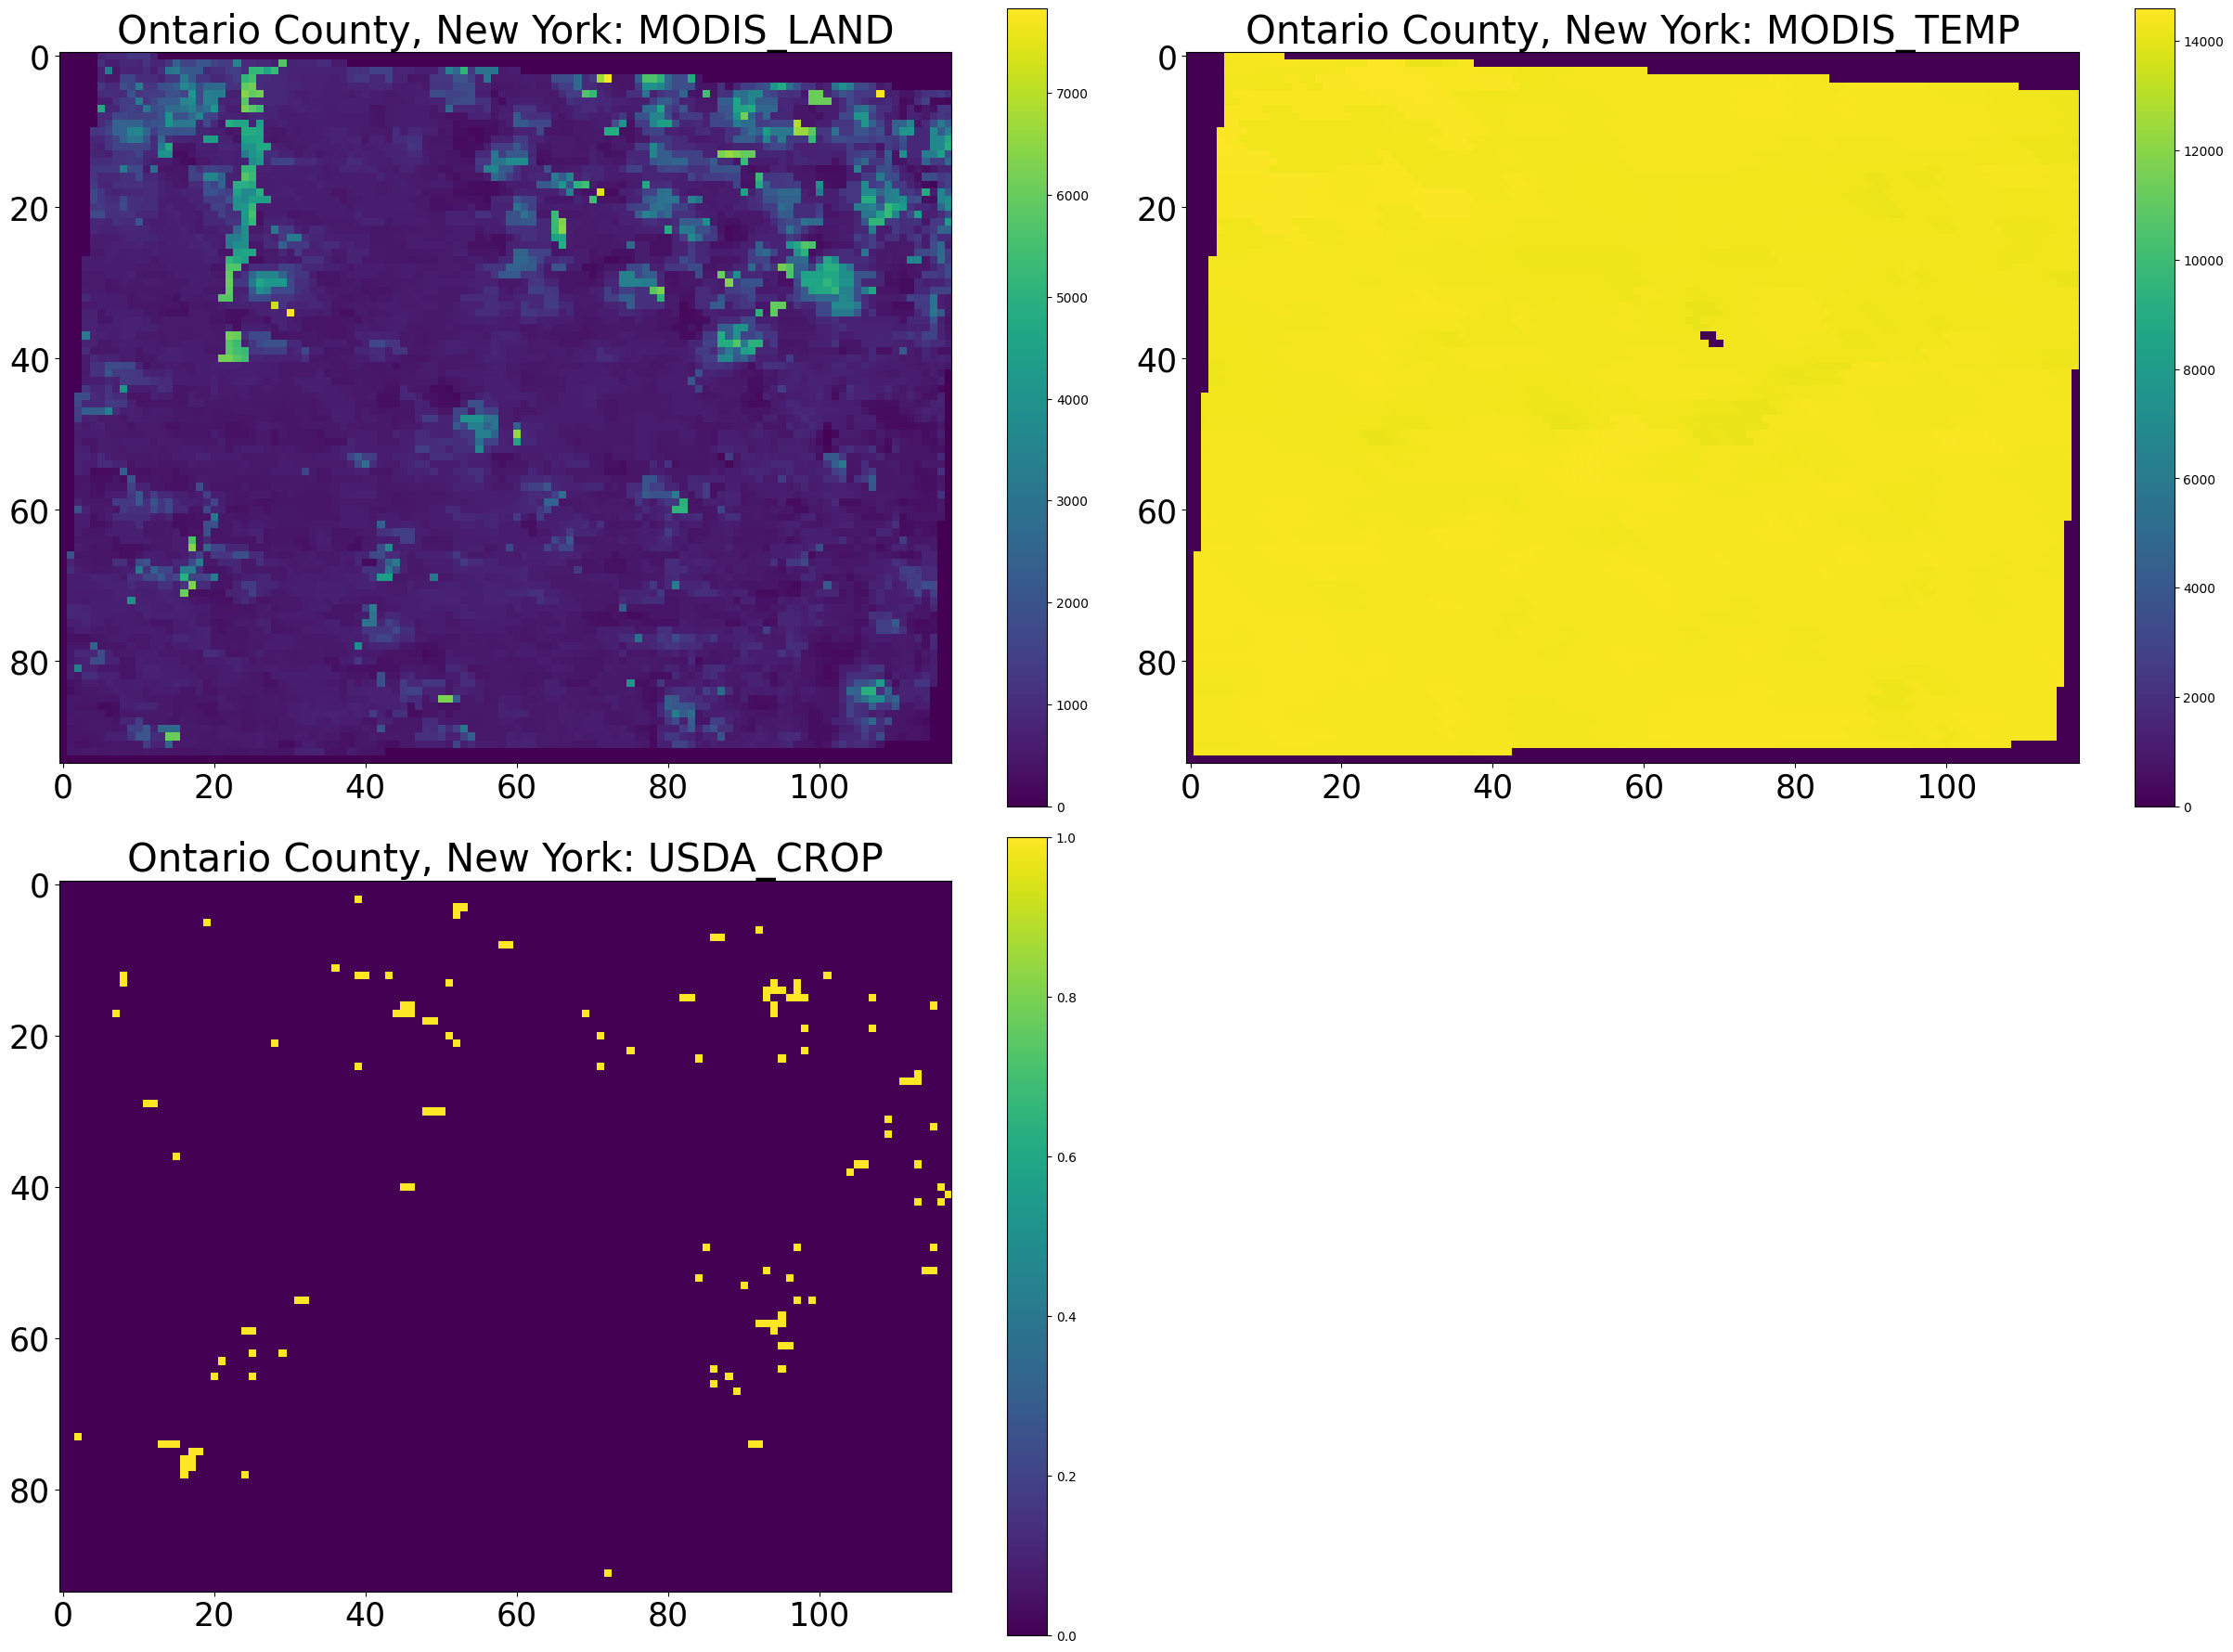

In [8]:
# Example Images
# test_county = '31_109' 
# test_county = '19_165'
# test_county = '17_123'
# test_county = '36_089'
# test_county = '22_107'
test_county = '37_151'

path = ['MODIS_LAND/MODIS_LAND_', 'MODIS_TEMP/MODIS_TEMP_', 'USDA_CROP/USDA_CROP_']
plt.figure(figsize=(25,18))
for i, file in enumerate(path):
    test = imread('data/' + file + test_county + '.tif')
    plt.subplot(2, 2, i+1) 
    plt.imshow(test[:, :, 0])
    plt.title('Ontario County, New York: ' + file.split('/')[1][:-1], fontsize=30)
    plt.colorbar()
    plt.xticks(fontsize=25)
    plt.yticks(fontsize=25)
plt.savefig('Example Images', dpi=500)
plt.tight_layout()
plt.show()

In [29]:
# Find the intersection of dates
modis_temp_dates = set(dates_of_images['MODIS_TEMP'])
modis_land_dates = set(dates_of_images['MODIS_LAND'])

common_dates = modis_temp_dates.intersection(modis_land_dates)

# Convert back to lists 
common_dates_list = list(common_dates)

# Update the dates_of_images dictionary with the common dates
dates_of_images['MODIS_TEMP'] = common_dates_list
dates_of_images['MODIS_LAND'] = common_dates_list

In [31]:
# Processing image 
def image_processing_I(filedata):
    path, folder, nband, fips_data, dates_of_images = filedata
    new_dates = {}
    for state, county in tqdm(fips_data):
        # Create path
        imname_mask = folder[0] + '_' + str(state) + '_' + str(county) + '.tif'
        imname_folder_1 = folder[1] + '_' + str(state) + '_' + str(county) + '.tif' 
        imname_folder_2 = folder[2] + '_' + str(state) + '_' + str(county) + '.tif'

        try:
            # Reading figures
            mask = imread(path + folder[0] + '/' + imname_mask)
            img_1 = imread(path + folder[1] + '/' + imname_folder_1)
            img_2 = imread(path + folder[2] + '/' + imname_folder_2)
        except FileNotFoundError:
            # print(f"Files not found for state {state} and county {county}. Skipping...")
            continue
     
        mask, new_dates[folder[0]] = filter_year(['2018', '2023'], mask, nband[0], dates_of_images[folder[0]])
        img_1, new_dates[folder[1]] = filter_year(['2018', '2023'], img_1, nband[1], dates_of_images[folder[1]])
        img_2, new_dates[folder[2]] = filter_year(['2018', '2023'], img_2, nband[2], dates_of_images[folder[2]])
        
        # Making sure the bands of the figure are correct
        if (img_1.shape[2]/nband[1] != img_2.shape[2]/nband[2]):
            print("image1 shape", img_1.shape)
            print("image2 shape", img_2.shape)
            print("nband", nband)
            print(img_1.shape[2]/nband[1], img_2.shape[2]/nband[2])
            raise ValueError('Dimension of the matrix is not correct.')

        # Zero fill NaN
        img_2 = zero_fill(img_2)

        if count_img_nan(img_2) > 0:
            print('The number of NaN in MODIS_LAND, Temp, and USDA_CROP are {}, {}, and {}. \
            in {} state and {} county'.format(count_img_nan(img_1), count_img_nan(img_2), count_img_nan(mask), state, county))

        # Splitting images by year
        img_1_list = split_img_by_year(img_1, nband[1], new_dates[folder[1]])
        img_2_list = split_img_by_year(img_2, nband[2], new_dates[folder[2]])

        # Masking
        for i, img_year in enumerate(img_1_list):
            # Check if i is within the valid range
            if i < mask.shape[2]:
                for j in range(img_year.shape[2]):
                    # Check if j is within the valid range
                    if j < mask.shape[2]:
                        img_1_list[i][:, :, j] = img_1_list[i][:, :, j] * mask[:, :, i]

        for i, img_year in enumerate(img_2_list):
            # Check if i is within the valid range
            if i < mask.shape[2]:
                for j in range(img_year.shape[2]):
                    # Check if j is within the valid range
                    if j < mask.shape[2]:
                        img_2_list[i][:, :, j] = img_2_list[i][:, :, j] * mask[:, :, i]

        
        year_list = list(range(2018, 2023))
        output_folder = os.path.join(output_path, folder[1])
        os.makedirs(output_folder, exist_ok=True)

        # export images, this part can be improved by using HDF5
        for i, img_year in enumerate(img_1_list):
            np.save(os.path.join(output_folder, f"{year_list[i]}_{state}_{county}.npy"), img_year) 

        # Repeat for the second folder
        output_folder = os.path.join(output_path, folder[2])
        os.makedirs(output_folder, exist_ok=True)

        for i, img_year in enumerate(img_2_list):
            np.save(os.path.join(output_folder, f"{year_list[i]}_{state}_{county}.npy"), img_year)


if __name__ == "__main__":
    path = 'data/'
    folder = ['USDA_CROP', 'MODIS_LAND', 'MODIS_TEMP']
    nband = [1, 7, 2]
    output_path = "/home/kaywee/Documents/wee's things/cds-corn-prediction/"
    filedata = path, folder, nband, fips_data, dates_of_images
    
    image_processing_I(filedata)

100%|██████████| 1887/1887 [08:33<00:00,  3.67it/s]


In [36]:
# Binning images 

def create_input_3D(input_dir, fips, output_dir):
    
    resolution = 128
    for fip in tqdm(fips):
        year = fip[0]
        state = fip[1]
        county = fip[2]
        
        try:
            # Reading figures
            img_1 = np.load(input_dir[0] + str(year) +'_' + str(state) + '_' + str(county) + '.npy')
            img_2 = np.load(input_dir[1] + str(year) +'_' + str(state) + '_' + str(county) + '.npy')
        except FileNotFoundError:
            # print(f"Files not found for state {state} and county {county}. Skipping...")
            continue

        bin_MODIS_LAND = get_bin(img_1, [[0, 4000]]*4 + [[0, 5000]]*2 + [[0, 4000]], 7, resolution)
        bin_MODIS_TEMP = get_bin(img_2, [[13500, 15250], [13000, 14250]], 2, resolution)

        bin_all = np.concatenate([bin_MODIS_LAND, bin_MODIS_TEMP], axis=0)

        np.save(output_dir + '//' + str(year) + '_' + str(state) + '_' + str(county), bin_all)

if __name__ == "__main__":
    
    fips = corn_grain[['YEAR', 'STATE_FIPS', 'COUNTY_FIPS']][corn_grain['YEAR'] >= 2018]
    fips = fips[((fips['STATE_FIPS'] != 51) | (fips['COUNTY_FIPS'] != 131)) & \
               ((fips['STATE_FIPS'] != 46) | (fips['COUNTY_FIPS'] != 102))]
    
    pd.DataFrame(fips).to_csv("data/processed_fips.csv")
 
    fips = fips[['YEAR', 'STATE_FIPS', 'COUNTY_FIPS']].values

    # fips.to_csv('data/processed_fips.csv')
    
    create_input_3D(["/home/kaywee/Documents/wee's things/cds-corn-prediction/temp_data/MODIS_LAND/", 
                    "/home/kaywee/Documents/wee's things/cds-corn-prediction/temp_data/MODIS_TEMP/"], 
                    fips, \
                    'data/PROCESSED')

  0%|          | 0/8675 [00:00<?, ?it/s]

/home/kaywee/Documents/wee's things/cds-corn-prediction/helper_functions.py:285: RuntimeWarning: invalid value encountered in divide
  y[band, :, time] = np.array([count[i+1] for i in range(resolution)])/len(x)
100%|██████████| 8675/8675 [21:14<00:00,  6.80it/s]  


In [ ]:
# Reshaping (nband, resolution, frame per year) to (frames, 1, resolution, nband)
nband = 9
resolution = 128

for file_name in tqdm(glob.glob('data/PROCESSED/*.npy')):
    year, state, county = file_name[15:-4].split('_')
    print(file_name)
    processed_img = np.load(file_name)
    output_name = ('_').join([year, state, county])
    
    frames = processed_img.shape[2]
    new_processed_img = np.zeros((frames, 1, resolution, nband))
    for frame in range(frames):
        for band in range(nband):
            new_processed_img[frame, :, :, band] = processed_img[band, :, frame]
    np.save('data/PROCESSED_II/' + output_name + '.npy', new_processed_img)

In [2]:
# Remove nan entries since the mask from satellites can cause some images become all zeros
# although the USDA data says it has yields. This discrepancy causes the image to be nan during the binning process.
count_nonnan = 0
removed_ID = []
for filename in tqdm(glob.glob('data/PROCESSED_II/*.npy')):
    file = np.load(filename)
    if np.sum(np.isnan(file)) == 0:
        np.save('data/PROCESSED_III/' + filename[18:-4] + '.npy', file)
        count_nonnan += 1
    else:
        removed_ID += [filename[18:-4]]
print('The number of processed files with no nan is {} from the original of {}.'.format(count_nonnan, len(glob.glob('data/PROCESSED_II/*.npy'))))
pickle.dump(removed_ID, open("data/removed_ID.p", "wb" ) )

  0%|          | 0/2980 [00:00<?, ?it/s]

100%|██████████| 2980/2980 [00:03<00:00, 875.37it/s]

The number of processed files with no nan is 1832 from the original of 2980.


In [3]:
# Preparing {county_year:yield} dictionary data for model evaluation
# Load fips and other data
fips = pd.DataFrame(pd.read_csv('data/processed_fips.csv').drop(['Unnamed: 0'], axis=1))
corn_grain = pd.read_csv('corn_grain.csv').drop(['Unnamed: 0'], axis=1)
fips_yields = corn_grain.merge(fips)[['YEAR', 'STATE_FIPS', 'COUNTY_FIPS', 'YIELD']].astype(str)
fips_yields['YIELD'] = fips_yields['YIELD'].astype(float)
fips_yields['ID'] = fips_yields.apply(lambda row: row['YEAR'] + '_' + row['STATE_FIPS'] + \
                                      '_' + row['COUNTY_FIPS'], axis=1)
# Remove the IDs with Nans
removed_ID = pd.DataFrame(removed_ID, columns=['ID'])
fips_yields = fips_yields[~fips_yields['ID'].isin([i[0] for i in removed_ID.values.tolist()])]

fips_yields = fips_yields.set_index('ID')
display(fips_yields.head())

print('\n' + '#'*13, 'YIELD MAPPING', '#'*13)

yields_train = fips_yields[['YIELD']][fips_yields['YEAR'] != '2021'].to_dict()['YIELD'] # data from year 2018-2020
yields_test = fips_yields[['YIELD']][fips_yields['YEAR'] == '2021'].to_dict()['YIELD'] # data form year 2021

keys = ['train', 'validation']
values = [yields_train, yields_test]
yields = {key:value for key, value in zip(keys, values)}

for key in list(yields['train'].keys())[0:5]:
    print(key, '=',  yields['train'][key])
print('#'*41)
pickle.dump(yields, open("data/yields.p", "wb" ) )

,YEAR,STATE_FIPS,COUNTY_FIPS,YIELD
ID,,,,
2018_1_1,2018,1,1,165.6
2018_1_47,2018,1,47,137.3
2018_1_51,2018,1,51,170.5
2018_1_105,2018,1,105,145.2
2018_1_3,2018,1,3,152.0



############# YIELD MAPPING #############
2018_1_1 = 165.6
2018_1_47 = 137.3
2018_1_51 = 170.5
2018_1_105 = 145.2
2018_1_3 = 152.0
#########################################
